In [1]:
import os
import torch
import torch.nn.functional as F

def step_to_block(step, block_size=32, block_id_base=0):
    """
    Map global step -> (block_id, step_block) matching your filename convention.
    If filenames use block_id starting from 1, keep block_id_base=1.
    If filenames use block_id starting from 0, set block_id_base=0.
    """
    block_idx0 = step // block_size           # 0..num_blocks-1
    step_block = step % block_size            # 0..block_size-1
    block_id = block_idx0 + block_id_base
    return block_id, step_block

def load_kv_tensor(path):
    """
    Robust loader: handles tensor directly, or dict containing 'k'/'v', etc.
    """
    obj = torch.load(path, map_location="cpu")
    if torch.is_tensor(obj):
        return obj
    if isinstance(obj, dict):
        # common keys
        for key in ["k", "v", "key", "value", "K", "V"]:
            if key in obj and torch.is_tensor(obj[key]):
                return obj[key]
    raise TypeError(f"Unrecognized content in {path}: {type(obj)}")

def collect_token_vectors(
    records_dir,
    sample_id: int,
    layer: int,
    token_pos: int,
    kind: str = "k",              # "k" or "v"
    total_steps: int = 128,
    block_size: int = 32,
    block_id_base: int = 1,
    expect_shape: str = "seq_hidden",  # or "heads_seq_dim" if you saved that way
):
    """
    Returns X: [total_steps, hidden] (float32 on CPU)
    Assumes each record file contains K/V for the whole sequence at that step & layer.
    """
    vecs = []
    for step in range(total_steps):
        block_id, step_block = step_to_block(step, block_size, block_id_base)
        fname = f"batch_{sample_id}_{block_id}_{step_block}_{layer}_{kind}_previous.pt"
        fpath = os.path.join(records_dir, fname)
        if not os.path.exists(fpath):
            raise FileNotFoundError(f"Missing file: {fpath}")

        T = load_kv_tensor(fpath).squeeze(0)  # tensor for this step

        # Expected common format: [seq, hidden] (e.g., [128, 4096])
        if expect_shape == "seq_hidden":
            # token vector: [hidden]
            v = T[token_pos]
        else:
            # If you stored as [heads, seq, head_dim] or [seq, heads, head_dim], adapt here.
            # Example for [heads, seq, head_dim]:
            # v = T[:, token_pos, :].reshape(-1)  # flatten heads
            raise ValueError("Set expect_shape to 'seq_hidden' or customize this block.")

        vecs.append(v)

    X = torch.stack(vecs, dim=0).detach().float()  # [steps, hidden]
    return X

def cosine_sim_matrix(X):
    """
    X: [T, D]
    returns S: [T, T] cosine similarity in [-1, 1]
    """
    Xn = F.normalize(X, dim=1, eps=1e-8)
    return Xn @ Xn.T


In [2]:
import matplotlib.pyplot as plt

def plot_heatmap(S, title="", savepath=None, vmin=-1.0, vmax=1.0):
    plt.figure(figsize=(7, 6), dpi=150)
    im = plt.imshow(S.cpu().numpy(), aspect="auto", cmap="RdYlGn", vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04, label="cosine similarity")
    plt.xlabel("diffusion step")
    plt.ylabel("diffusion step")
    plt.title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()


In [ ]:
sample_id = 0
records_dir = "kv_states"

from datasets import Dataset, load_from_disk
ds_steplog = load_from_disk(f'{records_dir}/{sample_id}.steplog')
dict_token_step = {idx_token[0]:step for step, idx_token in enumerate(ds_steplog['idx_token']) }

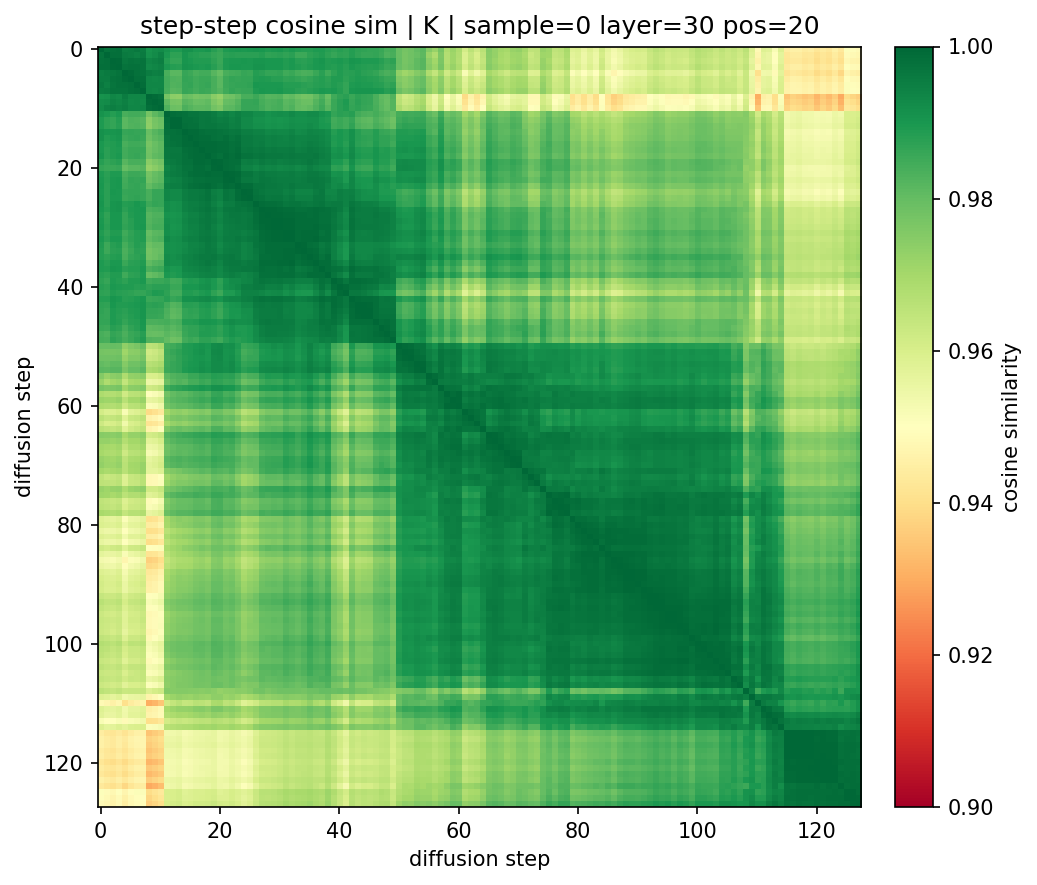

In [38]:
layer = 30
len_prompt = 64
token_pos = 20          # global token index in [0..127]
is_prompt = True

kind = "k"      
token_pos_g = token_pos if is_prompt else len_prompt + token_pos 
step_unmasked = 'x' if is_prompt else dict_token_step[token_pos_g]
vmin = 0.9 if is_prompt else 0.5

X = collect_token_vectors(
    records_dir=records_dir,
    sample_id=sample_id,
    layer=layer,
    token_pos=token_pos_g,
    kind=kind,
    total_steps=128,
    block_size=32,
    block_id_base=0,    # IMPORTANT: matches your example batch_0_1_16_16_k.pt
)

S = cosine_sim_matrix(X)

plot_heatmap(
    S,
    title=f"step-step cosine sim | {kind.upper()} | sample={sample_id} layer={layer} pos={token_pos}",
    savepath=f"heatmap_{kind}_b{sample_id}_l{layer}_p{token_pos}_s{step_unmasked}.png",
    vmin=vmin, vmax=1.0
)

In [ ]:
from datasets import Dataset, load_from_disk
ds_steplog = load_from_disk(f'{records_dir}/{sample_id}.steplog')
dict_token_step = {idx_token[0]:step for step, idx_token in enumerate(ds_steplog['idx_token']) }

In [16]:
ds_steplog['idx_token']

Column([[65], [66], [64], [68], [69], ...])

In [23]:
for i in ds_steplog['idx_token']:
    print(i)
# end

[65]
[66]
[64]
[68]
[69]
[67]
[72]
[73]
[70]
[71]
[74]
[79]
[80]
[78]
[76]
[75]
[81]
[82]
[90]
[91]
[89]
[88]
[87]
[93]
[92]
[95]
[94]
[77]
[85]
[86]
[83]
[84]
[96]
[97]
[98]
[99]
[105]
[120]
[122]
[121]
[123]
[119]
[106]
[110]
[111]
[112]
[113]
[118]
[104]
[102]
[100]
[101]
[115]
[116]
[103]
[117]
[127]
[126]
[107]
[109]
[108]
[124]
[125]
[114]
[146]
[143]
[144]
[145]
[147]
[151]
[158]
[159]
[155]
[137]
[138]
[141]
[150]
[142]
[139]
[140]
[133]
[129]
[128]
[154]
[153]
[152]
[134]
[136]
[135]
[148]
[149]
[130]
[131]
[132]
[156]
[157]
[160]
[161]
[162]
[163]
[165]
[166]
[168]
[169]
[174]
[176]
[175]
[177]
[178]
[180]
[179]
[183]
[184]
[185]
[190]
[181]
[182]
[167]
[164]
[172]
[173]
[171]
[170]
[186]
[188]
[187]
[189]
[191]


In [22]:
dict_token_step[48]

KeyError: 48